##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

&lt;style&gt; td {   text-align: center; }  th {   text-align: center; } &lt;/style&gt;

# 눈에 띄는 이미지 캡션

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서보기</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

아래 예와 같은 이미지가 주어졌을 때의 목표는 "파도를 타는 서퍼"와 같은 캡션을 생성하는 것입니다.

<table style="text-align: center;">
<tr>
  <td><img src="https://tensorflow.org/images/imcap_prediction.png" data-md-type="image" alt="예측"></td>
</tr>
<tr>
  <th>서핑하는 남자, 출처: <a href="https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg">wikimedia</a>
</th>
</tr>
</table>

여기에서 사용된 모델 아키텍처는 [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)의 영감을 받았지만 2단 레이어 트랜스포머 디코더를 사용하도록 업데이트되었습니다. 이 튜토리얼을 최대한 활용하려면 [텍스트 생성](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq 모델 및 어텐션](https://www.tensorflow.org/text/tutorials/nmt_with_attention) 또는 [트랜스포머](https://www.tensorflow.org/text/tutorials/transformer)를 약간 경험해 보셔야 합니다.

이 튜토리얼에서 빌드된 모델 아키텍처는 아래와 같습니다. 특성은 이미지에서 추출되어 트랜스포머 디코더의 크로스 어텐션 레이어로 전달되었습니다.

<table>
<tr>
  <th>모델 아키텍처</th>
</tr>
<tr>
  <td>    <img width="400" src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png">
</td>
</tr>
</table>

트랜스포머 디코더는 주로 어텐션 레이어에서 빌드됩니다. 이는 셀프 어텐션을 사용하여 생성되는 시퀀스를 처리하고 크로스 어텐션을 사용하여 이미지를 처리합니다.

크로스 어텐션 레이어의 어텐션 가중치를 검사하면 모델이 단어를 생성할 때 이미지의 어떤 부분을 모델이 보고 있는지 알 수 있습니다.

![예측](https://tensorflow.org/images/surf.jpg)

이 노트북은 엔드 투 엔드 예제입니다. 노트북을 실행하면 노트북은 데이터세트를 다운로드하며 이미지 특성을 추출하고 캐싱하여 디코더 모델을 훈련합니다. 그런 다음 모델을 사용하여 새로운 이미지에 캡션을 생성합니다.

## 설치

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [3]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0


In [4]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 814.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.19.1 which is incompatible.


In [5]:
!pip install einops

이 튜토리얼은 주로 데이터세트를 로딩하기 위해 가져오기를 많이 사용합니다.

In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

## [선택 사항] 데이터 처리

이 섹션은 캡션 데이터세트를 다운로드하고 훈련을 위해 이를 준비합니다. 입력 텍스트를 토큰화하고 사전 훈련된 특정 추출 모델을 통해 모든 이미지를 실행한 결과를 캐싱합니다. 이는 이 섹션의 모든 것을 이해하는 데 중요하지는 않습니다.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">토글 섹션</button>
</section>


### 데이터세트 선택

이 튜토리얼은 데이터세트를 선택할 수 있도록 설정되었습니다. [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) 또는 [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) 데이터세트의 작은 슬라이스 중 하나입니다. 이 두 가지는 처음부터 다운로드되고 변환되었지만 [TensorFlow Datasets](https://www.tensorflow.org/datasets)([Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) 및 전체 [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions))에서 사용할 수 있는 캡션 데이터세트를 사용하기 위해 튜토리얼을 변환하는 것은 어렵지 않습니다.


#### Flickr8k

In [8]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [9]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path

    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)

    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')

  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### 데이터세트 다운로드

Flickr8k는 이미지당 5개의 캡션과 더욱 소규모의 다운로드를 위한 더 많은 데이터를 포함하고 있어 좋은 선택입니다.

In [12]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

위의 두 데이터세트에 대한 로더는 `(image_path, captions)` 쌍을 포함하는 `tf.data.Dataset`를 반환합니다. Conceptual Captions는 이미지당 캡션 1개를 포함하는 한편 Flickr8k는 이미지당 5개의 캡션을 포함합니다.

In [ ]:
train_raw.element_spec

In [13]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### 이미지 특성 추출기

각 이미지에서 특성을 추출하기 위해 이미지 모델(imagenet에서 사전 훈련됨)을 사용할 것입니다. 모델은 이미지 분류기로 훈련되었지만, 설정 `include_top=False`는 최종 분류 레이어 없이 모델을 반환하므로 특성 맵의 최종 레이어를 사용할 수 있습니다.


In [14]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


다음은 모델에 맞게 이미지를 로드하고 크기를 조정하는 함수입니다.

In [15]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

모델은 입력 매치의 각 이미지에 대한 특성 맵을 반환합니다.

In [16]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### 텍스트 토크나이저/벡터라이저 설정

[TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) 레이어를 사용하여 다음 단계에 따라 텍스트 캡션을 정수 시퀀스로 변환하게 됩니다.

- [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt)를 사용하여 모든 캡션을 반복하고 캡션을 단어로 분할하고 상위 단어의 어휘를 계산합니다.
- 각 단어를 어휘의 인덱스에 매핑하여 모든 캡션을 토큰화합니다. 모든 출력 시퀀스는 길이 50으로 채워집니다.
- 단어에서 인덱스로, 인덱스에서 단어로의 매핑을 생성하여 결과를 표시합니다.

In [17]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [18]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [19]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [20]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('in'),
 np.str_('the'),
 np.str_('on'),
 np.str_('is'),
 np.str_('and')]

In [21]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [22]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [23]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [24]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### 데이터세트 준비

`train_raw` 및 `test_raw` 데이터세트는 1:많은 `(image, captions)` 쌍을 포함합니다.

이 함수는 이미지를 복제하여 캡션에 1:1 이미지가 있게 됩니다.

In [25]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [26]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


keras 훈련과 호환되려면 데이터세트는 `(inputs, labels)` 쌍을 포함해야 합니다. 텍스트 생성의 경우 토큰은 한 단계 이동된 입력과 라벨입니다. 이 함수는 `(images, texts)` 쌍을 `((images, input_tokens), label_tokens)` 쌍으로 변환합니다.

In [27]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

이 함수는 연산을 데이터세트에 추가합니다. 단계는 다음과 같습니다.

1. 이미지를 로드합니다(로드에 실패한 이미지는 무시합니다).
2. 이미지를 복제하여 캡션의 숫자와 매칭합니다.
3. `image, caption` 쌍을 섞고 리배치합니다.
4. 텍스트를 토큰화하고 토큰을 이동하여 `label_tokens`을 추가합니다.
5. `RaggedTensor` 표현에서 텍스트를 패딩 처리된 밀도 높은 `Tensor` 표현으로 변환합니다.

In [28]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

모델에 특성 추출기를 설치하고 다음과 같이 데이터세트에서 훈련할 수 있습니다.

In [29]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [30]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [선택 사항] 이미지 특성 캐싱하기

이미지 특성 추출기가 변경되지 않으며 이 튜토리얼은 이미지 증강을 사용하지 않으므로 이미지 특성은 캐싱될 수 있습니다. 텍스트 토큰화의 경우도 동일합니다. 캐시를 설정하는 데 드는 시간은 훈련 및 검증 중 각 epoch에서 다시 획득됩니다. 아래의 코드는 두 개의 함수인 `save_dataset` 및 `load_dataset`를 정의합니다.

In [31]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [32]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [00:58,  3.19it/s]
32it [00:10,  3.07it/s]


 </section>


## 훈련을 위한 데이터 준비

이러한 사전 처리 단계 후, 데이터세트는 다음과 같습니다.

In [33]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [34]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

데이터세트는 이제 keras 훈련에 적합한 `(input, label)` 쌍을 반환합니다. `inputs`은 `(images, input_tokens)` 쌍입니다. `images`는 특성-추출기 모델로 처리됩니다. `input_tokens`의 각 위치의 경우 모델은 지금까지의 텍스트를 보고 `labels`의 같은 위치에서 나열된 다음 텍스트를 예측하려고 시도합니다.

In [35]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 24)
(32, 24)


입력 토큰 및 라벨은 동일하며, 다음과 같이 한 단계만 이동하면 됩니다.

In [36]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2   12    8 1066  316 1164    7    2 1463 1509    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[   2   12    8 1066  316 1164    7    2 1463 1509    4    0    0    0
    0    0    0    0    0    0    0    0    0    0]


## 트랜스포머 디코더 모델

이 모델은 사전 훈련된 이미지 인코더가 충분하다고 가정하며 텍스트 디코더를 빌드하는 데만 집중합니다. 이 튜토리얼은 2단 레이어 트렌스포머 디코더를 사용합니다.

이 구현은 [Transformers 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)의 구현과 거의 동일합니다. 더 자세한 내용은 이를 다시 참조하세요.

<table>
<tr>
  <th>트랜스포머 인코더 및 디코더.</th>
</tr>
<tr>
  <td>    <img width="400" src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png">
</td>
</tr>
</table>

모델은 다음과 같은 세 가지 주요 부분으로 구현됩니다.

1. 입력 - 토큰 임베딩 및 위치 인코딩(`SeqEmbedding`).
2. 디코더 - 각각 다음을 포함하는 트랜스포머 디코더 레이어(`DecoderLayer`)의 스택
    1. 추후에 각 출력 위치가 지금까지 출력에 대해 처리할 수 있는 인과적 셀프 어텐션(`CausalSelfAttention`).
    2. 각 출력 위치가 입력 이미지를 추리할 수 있는 크로스 어텐션 레이어(`CrossAttention`).
    3. 각 출력 위치를 독립적으로 추가로 처리하는 피드 포워드 네트워크(`FeedForward`) 레이어.
3. 출력 - 출력 어휘에 대한 멀티 클래스 분류.


### 입력

입력 텍스트는 이미 토큰으로 분할되고 ID 시퀀스로 변환되었습니다.

CNN 또는 RNN와는 다르게 트랜스포머의 어텐션 레이어는 시퀀스의 순서에 대해 변하지 않는다는 점을 기억하세요. 몇몇 위치 입력이 없다면 시퀀스가 아닌 순서 없는 세트만 봅니다. 따라서 각 토큰 ID에 대한 단순한 벡터 임베딩 외에도 임베딩 레이어는 시퀀스 내 각 위치에 대한 임베딩 또한 포함합니다.

`SeqEmbedding` 레이어는 다음과 같이 정의됩니다.

- 각 토큰에 대한 임베딩 벡터를 검색합니다.
- 각 시퀀스 위치에 대한 임베딩 벡터를 검색합니다.
- 두 개를 모두 합합니다.
- `mask_zero=True`를 사용하여 모델에 대한 keras 마스크를 초기화합니다.

참고: 이 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)에서와 같이 고정된 임베딩을 사용하는 대신 위치 임베딩을 학습합니다. 임베딩을 학습하는 것은 코드가 약간 적지만 더 긴 시퀀스로 일반화되지는 않습니다.

In [37]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### 디코더

디코더는 표준 트랜스포머 디코더로, 각 세 개의 하위 레이어인 `CausalSelfAttention`, `CrossAttention` 및 `FeedForward`를 포함하는 `DecoderLayers`의 스택을 포함합니다. 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)과 거의 동일하며, 자세한 내용은 이를 참조하세요.

다음은 `CausalSelfAttention` 레이어입니다.

In [38]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


아래는 `CrossAttention` 레이어입니다. `return_attention_scores`를 사용하는 데 유의하세요.

In [39]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

아래는 `FeedForward` 레이어입니다. `layers.Dense` 레이어는 입력의 최종 축에 적용된다는 점을 기억하세요. 입력의 형태는 `(batch, sequence, channels)`이므로 `batch` 및 `sequence` 축에 걸쳐 포인트별로 자동으로 적용됩니다.

In [40]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


다음으로 이러한 세 가지 레이어를 더 큰 규모의 `DecoderLayer`에 배열합니다. 각 디코더 레이어는 시퀀스에 세 개의 더 작은 레이어를 적용합니다. 각 하위 레이어 다음의 `out_seq` 형태는 `(batch, sequence, channels)`입니다. 디코더 레이어는 또한 추후 시각화를 위한 `attention_scores`를 반환합니다.

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### 출력

출력 레이어는 각 위치에서 각 토큰에 대한 로짓 예측을 생성하려면 최소한 `layers.Dense` 레이어가 필요합니다.

하지만 이 작업을 좀 더 잘 수행할 수 있도록 추가할 수 있는 몇 가지 다른 특성이 있습니다.

1. **잘못된 토큰 처리**: 모델은 텍스트를 생성합니다. 패드, 알 수 없는, 또는 시작 토큰(`''`, `'[UNK]'`, `'[START]'`)을 생성해서는 안됩니다. 따라서 이들에 대한 편향을 큰 음수 값으로 설정합니다.

    > 참고: 손실 함수의 이러한 토큰 역시 무시해야 합니다.

2. **스마트 초기화**: 밀도가 높은 레이어의 기본 초기화는 거의 균일한 확률로 각 토큰을 초기에 예측하는 모델을 제공합니다. 실제 토큰 분포는 균일한 것과는 거리가 멉니다. 출력 레이어의 초기 편향을 위한 최적값은 각 토큰의 확률 로그입니다. 따라서 `adapt` 메서드를 포함해 토큰의 수를 세고 최적의 초기 편향을 설정합니다. 이는 균일한 분포(`log(vocabulary_size)`)의 엔트로피로부터의 분포의 한계 엔트로피(`-p*log(p)`)로 초기 손실을 줄입니다.


In [42]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


스마트 초기화는 초기 손실을 다음과 같이 상당히 줄입니다.

In [43]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:10<00:00, 91.55it/s] 


Uniform entropy: 8.52
Marginal entropy: 5.29


### 모델 빌드하기

모델을 빌드하려면 몇몇 부분을 조합해야 합니다.

1. 이미지 `feature_extractor` 및 텍스트 `tokenizer`.
2. 토큰 ID의 배치를 벡터 `(batch, sequence, channels)`로 변환하기 위한 `seq_embedding` 레이어.
3. 텍스트 및 이미지 데이터를 처리할 `DecoderLayers` 레이어의 스택.
4. 다음 단어가 무엇이어야 하는지에 대한 포인트별 예측을 반환하는 `output_layer`.

In [44]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

훈련을 위해 모델을 호출하면 `image, txt` 쌍을 수신합니다. 이 함수를 더욱 유용하게 하려면 입력에 대해 더 유연해지세요.

- 이미지에 3개의 채널이 있다면 feature_extractor를 통해 실행합니다. 그렇지 않으면 이미 실행된 것으로 가정합니다.
- 텍스트에 dtype `tf.string`이 있다면 토크나이저를 통해 실행하세요.

그런 다음 모델을 실행하는 것은 몇 단계만 수행하면 됩니다.

1. 추출된 이미지 특성을 평면화하여 디코더 레이어에 대한 입력이 될 수 있도록 합니다.
2. 토큰 임베딩을 검색합니다.
3. 이미지 특성 및 텍스트 임베딩에서 `DecoderLayer`의 스택을 실행합니다.
4. 출력 레이어를 실행하여 각 위치에서 다음 토큰을 예측합니다.


In [45]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [46]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### 캡션 생성하기

훈련을 시작하기 전에, 코드를 약간 작성해 캡션을 생성합니다. 이를 사용하여 훈련이 어떻게 진행되는지 확인합니다.

다음과 같이 테스트 이미지를 다운로드하여 시작합니다.

In [47]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


이 모델로 이미지를 캡션하려면 다음을 수행합니다.

- `img_features` 추출
- `[START]` 토큰으로 출력 토큰 목록 초기화.
- `img_features` 및 `tokens`를 모델로 전달.
    - 이는 로짓 목록을 반환합니다.
    - 이러한 로짓을 기반으로 다음 토큰을 선택합니다.
    - 토큰 목록에 이를 추가하고 루프를 계속합니다.
    - `'[END]'` 토큰이 생성되었다면 루프를 벗어나세요.

이를 위해 "간단한" 메서드를 추가합니다.

In [48]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

다음은 모델의 훈련되지 않은, 해당 이미지를 위해 생성된 일부 캡션으로 아직 의미가 그다지 없습니다.

In [49]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


a a a a a in a a a a a a
a man a a a with a
brown run two in


온도 매개변수를 통해 다음 세 모드 사이에 삽입할 수 있습니다.

1. 그리디 디코딩(`temperature=0.0`) - 각 단계에서 가장 확률이 높은 다음 토큰을 선택합니다.
2. 로짓(`temperature=1.0`)에 따른 랜덤 샘플링.
3. 균일 랜덤 샘플링(`temperature >> 1.0`).

모델이 훈련되지 않았고 빈도 기반 초기화를 사용하였으므로 "그리디" 출력은 (우선) 일반적으로 가장 일반적인 토큰인 `['a', '.', '[END]']`만 포함합니다.

## 훈련

모델을 훈련하려면 다음과 같은 몇몇 추가 컴포넌트가 필요합니다.

- 손실 및 메트릭
- 옵티마이저
- 선택적 콜백

### 손실 및 메트릭

다음은 마스킹 된 손실 및 정확성에 대한 구현입니다.

손실에 대한 마스크를 계산할 때 `loss < 1e8`를 주의하세요. 이 항은 `banned_tokens`에 대한 인공적이고 불가능할 정도로 높은 손실을 버립니다.

In [75]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(tf.cast(labels, tf.int64), preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### 콜백

훈련 중 피드백을 위해 `keras.callbacks.Callback`을 설정해 각 epoch의 끝에 서퍼 이미지에 대한 일부 캡션을 생성합니다.

In [76]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


이는 첫 번째가 "그리디"인 이전과 같은 이전 예시와 같은 세 개의 출력 문자열을 생성하여 각 단계에서 로짓의 argmax를 선택합니다.

In [77]:
g = GenerateText()
g.set_model(model)
g.on_epoch_end(0)

AttributeError: property 'model' of 'GenerateText' object has no setter

또한 `callbacks.EarlyStopping`을 사용하여 모델이 과적합을 시작할 때 훈련을 중단합니다.

In [78]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### 훈련

훈련을 구성하고 실행합니다.

In [79]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

빈도 보고를 더 많이 하려면, `Dataset.repeat()` 메서드를 사용하고 `steps_per_epoch` 및 `validation_steps` 인수를 `Model.fit`으로 설정합니다.

`Flickr8k`에서 이러한 설정을 통해 데이터세트에 대한 전체 전달은 배치가 900개 이상이지만 보고-epoch 아래에는 100개의 단계가 있습니다.

In [80]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.0448 - masked_acc: 0.1885



/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


a man in a in a in the
a man in a black a dog in the
three in the up the hat her park runs pulled

100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - loss: 4.8615 - masked_acc: 0.2197 - val_loss: 4.5231 - val_masked_acc: 0.2525
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 4.5403 - masked_acc: 0.2661

a man in a red and a man in a dog is running
a boy in a ocean
a rocky riding is brown air is running

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - loss: 4.4510 - masked_acc: 0.2789 - val_loss: 4.2543 - val_masked_acc: 0.2866
Epoch 3/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.2405 - masked_acc: 0.2976

a man in a red shirt is in the water
a man in the water in a field
a boy spraying a brown shirt in blue with a muddy is shirt is black sandy to on the at the

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - loss: 4.1962 - masked_acc: 0.3024 - val_loss: 4.0706 - val_masked_acc: 0.3065
Epoch 4/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.1016 - masked_acc: 0.31

훈련 실행 동안의 손실 및 정확성 플롯:

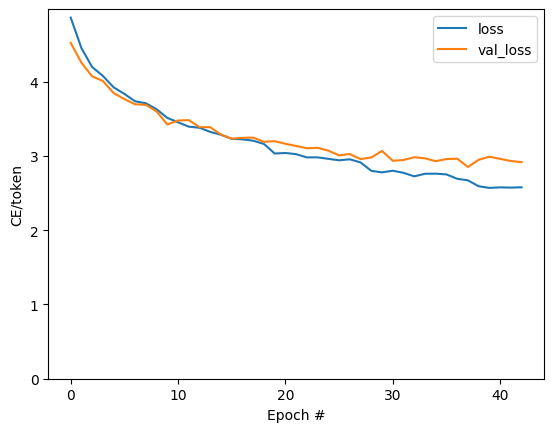

In [81]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

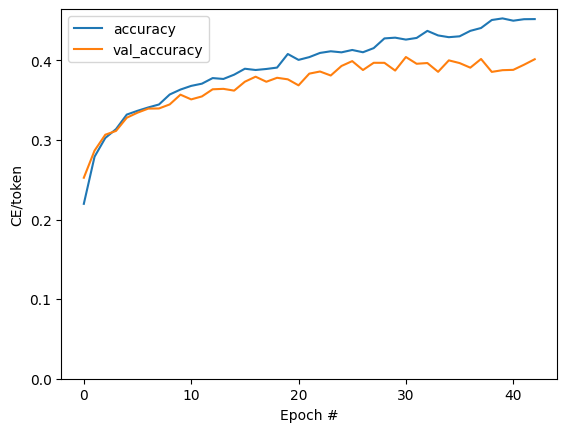

In [82]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## 어텐션 플롯

이제 훈련된 모델을 사용하여 이미지에서 해당 `simple_gen` 메서드를 실행합니다.

In [83]:
result = model.simple_gen(image, temperature=0.0)
result

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:946: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


'a man in a red wetsuit is surfing on a wave'

출력을 토큰으로 다시 분할합니다.

In [84]:
str_tokens = result.split()
str_tokens.append('[END]')

각 `DecoderLayers`는 `CrossAttention` 레이어에 대한 어텐션 스코어를 캐싱합니다. 각 어텐션 맵의 형태는 `(batch=1, heads, sequence, image)`입니다.

In [85]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 12, 49]), TensorShape([1, 2, 12, 49])]

따라서 `image` 축을 `height, width`로 다시 분할하는 한편 `batch` 축을 따라 맵을 스택한 다음 `(batch, heads)` 축에 대해 평균을 냅니다.


In [86]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

이제 각 시퀀스 예측을 위한 단일 어텐션 맵이 하나 있습니다. 각 맵의 값은 합계가 `1`이어야 합니다.

In [87]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        ], dtype=float32)>

따라서 다음은 출력에 대한 각 토큰을 생성하는 동안 모델이 어텐션에 주목하는 곳입니다.

In [88]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

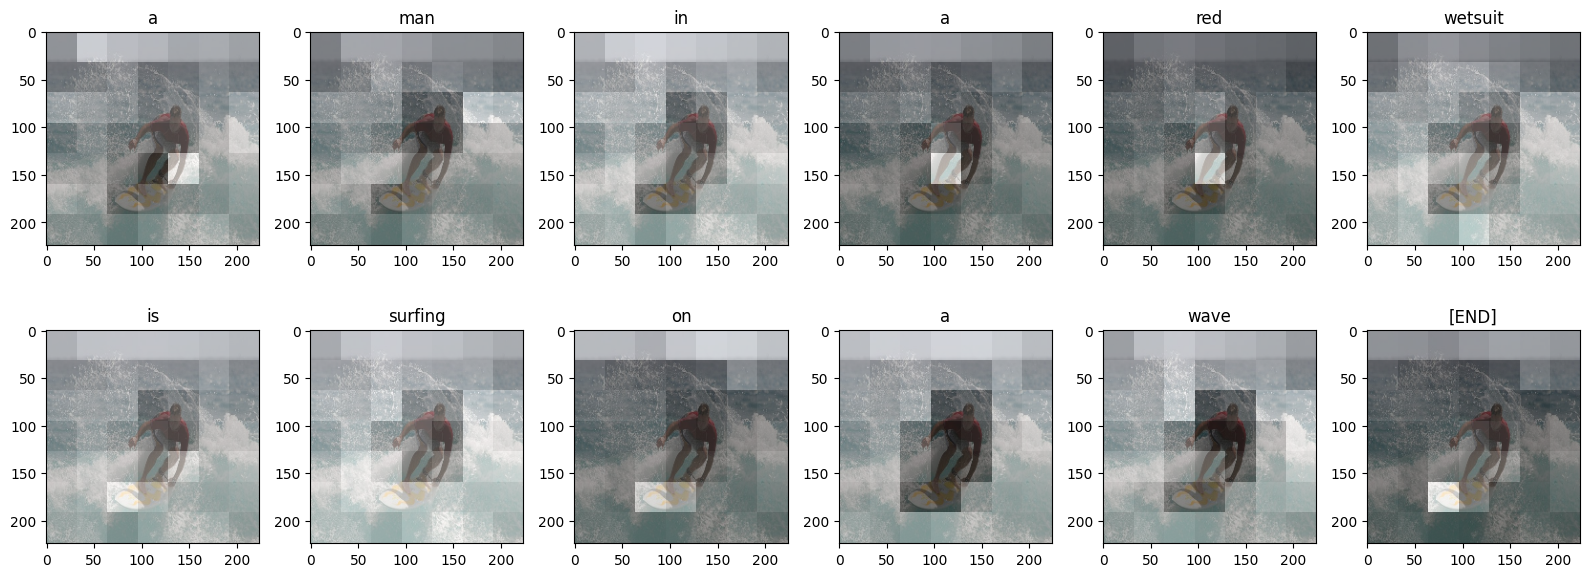

In [89]:
plot_attention_maps(image/255, str_tokens, attention_maps)

이제 더 유용한 함수로 함께 다음과 같이 통합합니다.

In [90]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


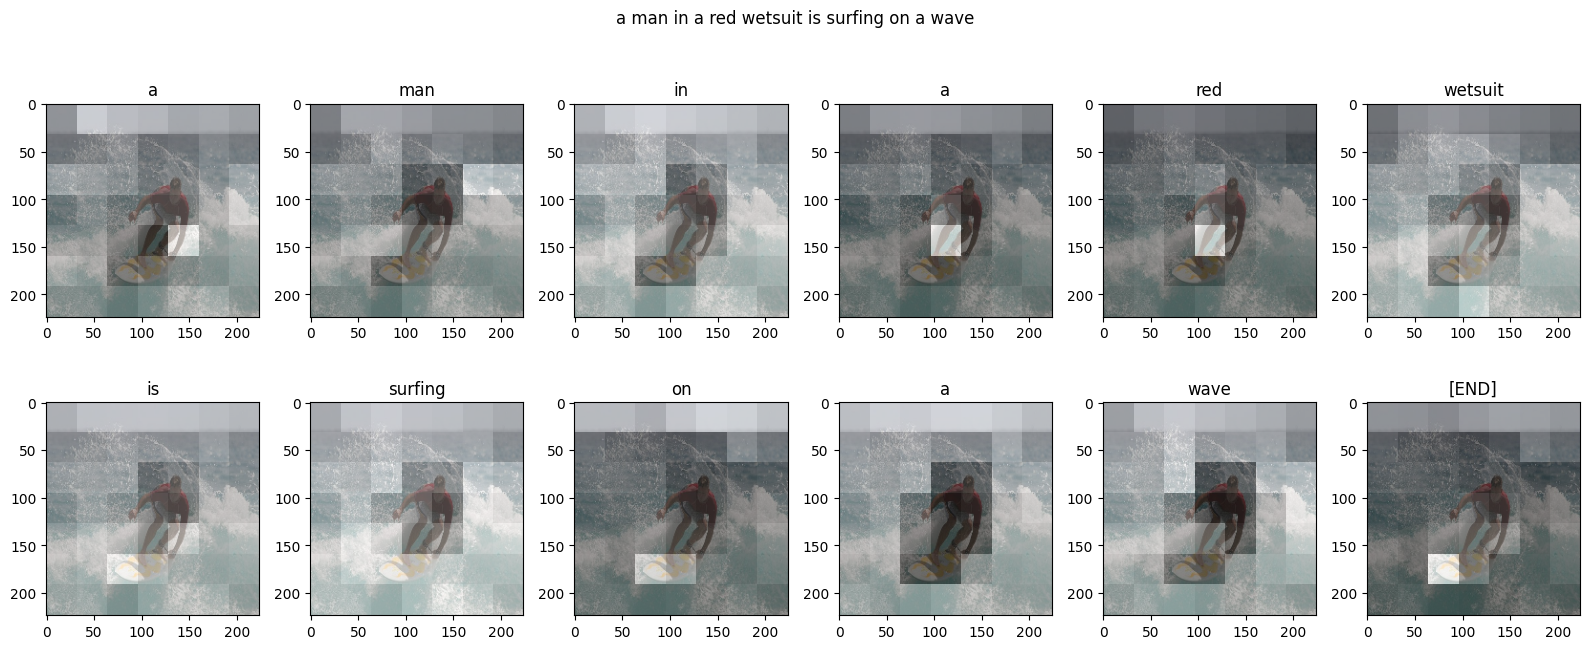

In [91]:
run_and_show_attention(model, image)

## 자체 이미지로 시도해보기

재미를 위해 방금 훈련한 모델로 자체 이미지를 캡션하는 데 사용할 수 있는 방법을 제공했습니다. 상대적으로 적은 양의 데이터로 훈련되었으므로 이미지가 훈련 데이터와 다를 수 있습니다(결과가 이상할 수 있습니다!).


67460/67460 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


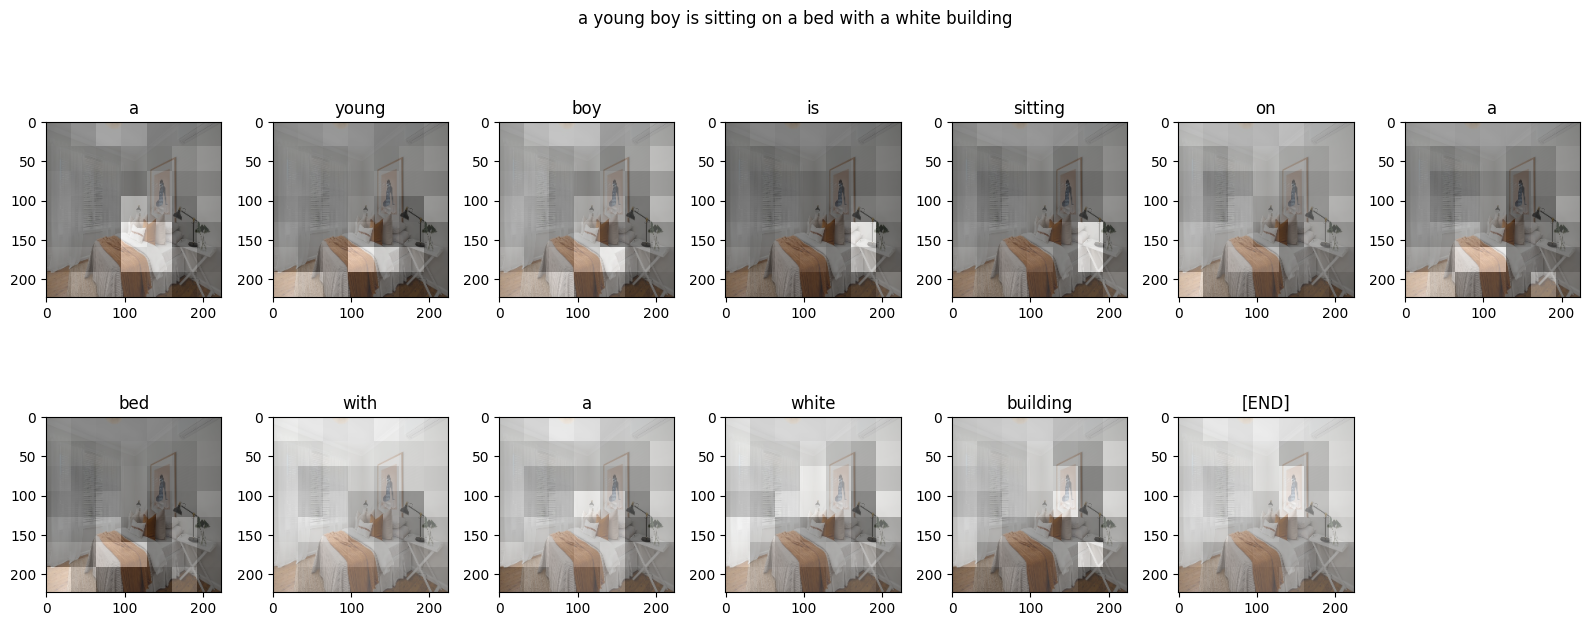

In [92]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)